In [7]:
import jax.random as jxr
import jax.numpy as jnp

import sys
sys.path.append('../')

import loader
import utils
import visualizations
import models
import inference

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Sample from head direction simulation

dataset_params = {
    'N': 10, # num neurons
    'D': 2, # num latents
    'T': 100, # num time points
    'B': 10, # num trials
    'speed': .2, # constant speed along circular track
    'tuning_peak': jnp.pi,  # tuning curve peaks
    'tuning_width': .5, # tuning curve widths
    'epsilon': .1, 
    'noise_scale': .1,
    'seed': 0,
    'props':{'train':.8,'test':.1,'validation':.1},
    'seeds':{'train':2,'test':0,'validation':3}
}
dataloader = loader.HeadDirectionSimulation(dataset_params)
y,t = dataloader.load_train_data()

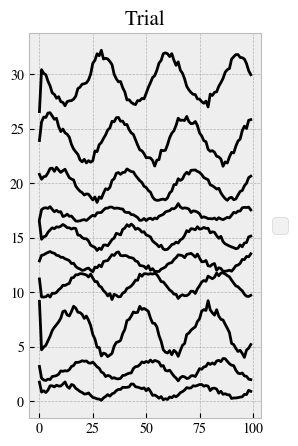

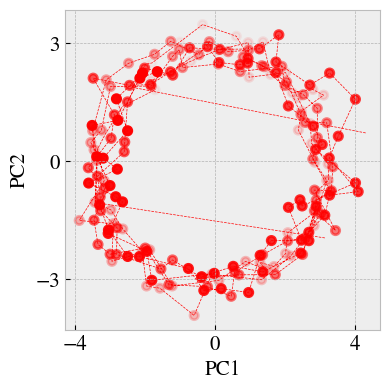

In [3]:
visualizations.plot_signals(
    [y[0]],
    titlestr='Trial'
)

visualizations.plot_states(
    [y[0],y[1]],
    ['y','y'],
    legend=False
)

In [4]:
# True parameters
omega = t[0,:,0]
theta = t[0,:,1]

true_As = dataloader.data['As_train'][0]
true_bs = dataloader.data['bs_train'][0]
true_Cs = dataloader.data['Cs_train'][0]


In [5]:
# Define model
model_params = {
    'D': 2,
    'wgp': {
        'basis': 'T1_basis', 
        'sigma': .5,
        'kappa': .1,
        'period': 2*jnp.pi
    },
    'seed': 0
}

_sigma, _kappa, _period = model_params['wgp']['sigma'], model_params['wgp']['kappa'], model_params['wgp']['period']
basis_funcs = eval('utils.'+model_params['wgp']['basis'])(5, _sigma, _kappa, _period)
# constant_basis = [lambda x: jnp.ones_like(x)/_period]

B,T,N = y.shape

A_prior = models.WeightSpaceGaussianProcess(basis_funcs, D1=model_params['D'], D2=model_params['D'])
b_prior = models.WeightSpaceGaussianProcess(basis_funcs, D1=model_params['D'], D2=1)
C_prior = models.WeightSpaceGaussianProcess(basis_funcs, D1=N, D2=model_params['D'])

model = models.wGPLDS(
    wgps={
        'A': A_prior, 
        'b': b_prior,
        'C': None,
    },
    state_dim=model_params['D'], 
    emission_dim=N,
)

In [8]:
# Fit model
seed = model_params['seed']
A_key, b_key, C_key = jxr.split(jxr.PRNGKey(seed), 3)

conditions = theta

initial_params = models.ParamswGPLDS(
    dynamics_gp_weights = A_prior.sample_weights(A_key),
    Q = 0.05 * jnp.eye(model_params['D']),
    R = 0.05 * jnp.eye(N),
    m0 = jnp.zeros(model_params['D']),
    S0 = jnp.eye(model_params['D']),
    emissions_gp_weights = None, # C_prior.sample_weights(C_key),
    bias_gp_weights=b_prior.sample_weights(A_key),
    Cs = jnp.tile(jxr.normal(C_key, (N, 2)), (T, 1, 1)),
    bs = None, # b_prior.sample(b_key, conditions).squeeze(),
)
params, log_probs = inference.fit_em(
    model,
    initial_params, 
    emissions=y, 
    conditions=t[:,:,1], 
    num_iters=500
)

if params.bs is None:
    params = params._replace(bs = b_prior(params.bias_gp_weights, conditions).squeeze())
if params.Cs is None:
    params = params._replace(Cs = C_prior(params.emissions_gp_weights, conditions))
if params.Cs.ndim == 2:
    params = params._replace(Cs = jnp.tile(params.Cs[None, :, :], (T, 1, 1)))

EM stopped at iteration 104 due to decreasing marginal_log_lik:  21%|██        | 103/500 [00:07<00:27, 14.68it/s]


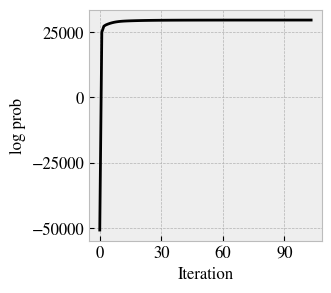

In [9]:
visualizations.plot_loss(log_probs,ylabel='log prob')

In [10]:
# Inferred parameters 
_, (filtered_means, _), (smoothed_means, smoothed_covs, _) = model.smoother(
    params, 
    emissions = y[0],
    inputs = theta,
)

reconstructed_ys = jnp.einsum('tnl,tl->tn', params.Cs, smoothed_means)
reconstructed_ys_covs = jnp.einsum('tnl,tlk,tmk->tnm', params.Cs, smoothed_covs, params.Cs)

_As = A_prior(params.dynamics_gp_weights, theta[:-1])
_bs = b_prior(params.bias_gp_weights, theta[:-1])

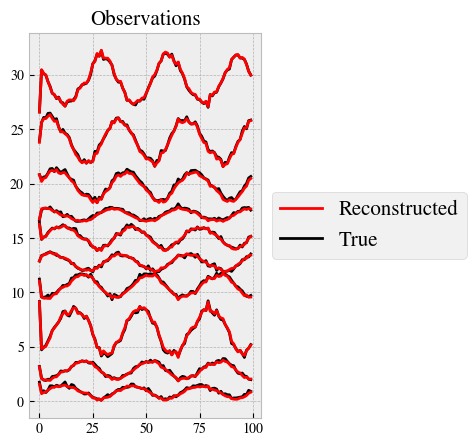

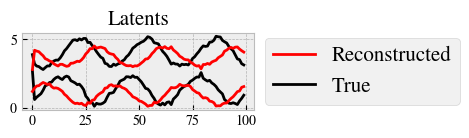

In [11]:
visualizations.plot_signals(
    [y[0],reconstructed_ys],
    titlestr='Observations',labels=['True','Reconstructed']
)

visualizations.plot_signals(
    [dataloader.data['x_train'][0],smoothed_means],
    titlestr='Latents',labels=['True','Reconstructed']
)

In [12]:
file = '../results/wRingAttractor/'

visualizations.time_var_dynamics(
    [dataloader.data['As_train'][0]-jnp.eye(2)[None], _As-jnp.eye(2)[None]],
    bs=[dataloader.data['bs_train'][0], _bs[:,:,0]],
    titlestr='True',
    save=True,
    scale=1e-1,
    xlim=[-3,3],
    ylim=[-3,3],
    file=file+'A_true'
)



MovieWriter ffmpeg unavailable; using Pillow instead.
